# Scraping real state attributes in Benito Juarez, CDMX

In [1]:
from bs4 import BeautifulSoup
import requests
from scrapy import Selector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import json
from pprint import pprint
from config import gkey

#my functions
from rdb_functions import clean_list
from rdb_functions import clean_list_url


We manually searched real state sales in metroscubicos.com in Alcaldia Benito Juarez.

In [2]:
url='https://inmuebles.metroscubicos.com/casas/venta/distrito-federal/benito-juarez/#origin=search&as_word=true'
#Get html content
html = requests.get( url ).content
sel = Selector( text = html )

## Getting all urls

In [3]:
path='//*[@class="andes-pagination__link"]'
urls=sel.xpath(path).extract()

#Getting the fist urls
urls=clean_list_url(urls)

there aren't further urls beyond the last from the previous query

In [4]:
#starting in last position from the previous query
url=urls[len(urls)-1]

html = requests.get( url ).content
sel = Selector( text = html )

#Getting the lasts urls
path='//*[@class="andes-pagination__link"]'
urls2=sel.xpath(path).extract()
urls2=clean_list_url(urls2)
urls.extend(urls2)

## Getting Attributes

In [5]:
#empty list of attributes
atr=[]
price=[]
status=[]
adress=[]

for url in urls:
    try:
        html = requests.get( url ).content
        sel = Selector( text = html )
    except:
        print(f'This url didnt work: \n {url}')
              
    try:
        path='//*[@class="item__attrs"]'
        aux=sel.xpath(path).extract()
        atr.extend(clean_list(aux))
    except:
        print(f'no attributes info in:\n{url}')
        
    try:
        path='//*[@class="price__fraction"]'
        aux=sel.xpath(path).extract()
        price.extend(clean_list(aux))
    except:
        print(f'no prices info in:\n{url}')

    try:
        path='//*[@class="item__info-title"]'
        aux=sel.xpath(path).extract()
        status.extend(clean_list(aux))
    except:
        print(f'no prices info in:\n{url}')
        
    try:
        path='//*[@class="item__title"]'
        aux=sel.xpath(path).extract()
        adress.extend(clean_list(aux))
    except:
        print(f'no prices info in:\n{url}')  
        

This url didnt work: 
 #
This url didnt work: 
 #


## Generating the Pandas

In [6]:
data=pd.DataFrame({'attributes':atr,'price':price,'status':status,'adress':adress})

In [7]:
data.tail(10)

,attributes,price,status,adress
998,326 m² de terreno,"15,500,000",Casa en venta,Napoles - Nápoles - Benito Juárez - Distrito ...
999,346 m² construidos | 4 recs.,"16,000,000",Casa en venta,Pitagoras - Narvarte Poniente - Benito Juárez...
1000,219 m² construidos | 4 recs.,"2,203,839",Casa en venta,BUFALO 00 - Del Valle Sur - Benito Juárez - D...
1001,150 m² construidos | 3 recs.,"1,400,000",Casa en venta,MANUEL LOPEZ COTILLA 934 - Del Valle Centro -...
1002,360 m² construidos | 4 recs.,"1,550,370",Casa en venta,ENRIQUE PESTALOZZI 0 - Narvarte - Benito Juár...
1003,299 m² construidos | 4 recs.,"12,500,000",Casa en venta,Enrique Rébsamen - Del Valle Centro - Benito ...
1004,386 m² construidos | 4 recs.,"6,680,000",Casa en venta,Martin Mendalde 0 - Del Valle Sur - Benito Ju...
1005,293 m² construidos | 3 recs.,"11,000,000",Casa en venta,SALOME PIÑA 00 - San José Insurgentes - Benit...
1006,180 m² construidos | 3 recs.,"1,155,966",Casa en venta,CASTILLA 142 - Alamos - Benito Juárez - Distr...
1007,350 m² construidos | 5 recs.,"9,500,000",Casa en venta,22 1 - San Pedro De Los Pinos - Benito Juárez...


## Printing the results

In [8]:
data.to_csv('benito_juarez.csv',index=False)

In [9]:
d2 = data['adress'] # Replacing values for later use
data['adress'] = [i.replace("-",",") for i in d2]

In [10]:
splt_att = data["attributes"].str.split("|", n = 2, expand = True) # splitting atribute to get new columns
splt_att.columns = ['x','rooms']
s_a2 = splt_att["x"].str.split(" ", n = 3, expand = True)
s_a2.columns = ['index', 'm2', 'metric','state']

m2 = s_a2['m2']
state = s_a2['state']
rooms = splt_att['rooms']

clean_data = pd.DataFrame({'m2': m2, 
                           'State': state, 
                           'Rooms': rooms, 
                           'Price': data['price'], 
                           'Status': data['status'],
                           'Adress': data['adress']})

clean_data.head()

,m2,State,Rooms,Price,Status,Adress
0,178,construidos,3 recs.,"5,700,000",Casa en venta,"Antillas 411 , Portales Norte , Benito Juárez..."
1,281,construidos,4 recs.,"8,500,000",Casa en venta,"Lopez Cotilla , Del Valle Sur , Benito Juárez..."
2,188,construidos,3 recs.,"6,950,000",Casa en venta,"ANAXAGORAS 0 , Narvarte Poniente , Benito Juá..."
3,423,construidos,None,"17,000,000",Casa en venta,"Del Valle Centro , Benito Juárez , Distrito F..."
4,488,construidos,6 recs.,"11,495,000",Casa en venta,"Xochicalco , Narvarte Poniente , Benito Juáre..."


In [11]:
clean_data.to_csv("./clean_data.csv") # printing to get coordinates

In [12]:
# Data files, all of these census data was acquired from inegi.org.mx
Censo2010_ConjuntoDatos_path = "DATA_CENSOs/resultados_ageb_urbana_09_cpv2010.csv"
Censo2010_DiccionarioDatos_path = "DATA_CENSOs/fd_resultados_ageb_urbana_cpv2010.csv"
Censo2010_MetaDatos_path = "DATA_CENSOs/resultados_ageb_urbana_09_cpv2010"
Censo2020_ConjuntoDatos_path = "DATA_CENSOs/conjunto_de_datos_ageb_urbana_09_cpv2020.csv"
Censo2020_DiccionarioDatos_path = "DATA_CENSOs/diccionario_datos_ageb_urbana_09_cpv2020.csv"
Censo2020_MetaDatos_path = "DATA_CENSOs/metadatos_ageb_urbana_09_cpv2020"

# Read the data and the study results
Conjunto2010_metadata = pd.read_csv(Censo2010_ConjuntoDatos_path, encoding='ISO-8859-1')
Diccionario2010_metadata = pd.read_csv(Censo2010_DiccionarioDatos_path, encoding='ISO-8859-1')
Conjunto2020_metadata = pd.read_csv(Censo2020_ConjuntoDatos_path, encoding='ISO-8859-1')
Diccionario2020_metadata = pd.read_csv(Censo2020_DiccionarioDatos_path, encoding='latin1')


# Filter out AGEB in Benito Juarez

BenitoJuarez2010_metadata=Conjunto2010_metadata[Conjunto2010_metadata['nom_mun']=="Benito JuÃ¡rez"]
BenitoJuarez2020_metadata=Conjunto2020_metadata[Conjunto2020_metadata['NOM_MUN']=="Benito JuÃ¡rez"]


#format dfs for comparison
BenitoJuarez2010_metadata.columns=map(lambda x:str(x).upper(),BenitoJuarez2010_metadata.columns)



In [13]:
#clean BJ2010 data, remove non repeating colums

BJ210=BenitoJuarez2010_metadata.drop(columns=['PCON_LIM','PCLIM_MOT','PCLIM_VIS','PCLIM_LENG','PCLIM_AUD','PCLIM_MOT2',
                                       'PCLIM_MEN','PCLIM_MEN2','PSIN_LIM','PDER_SEGP','PCATOLICA','PNCATOLICA',
                                       'POTRAS_REL','PSIN_RELIG'])

#sort for easier cleaning
cols=BJ210.columns.tolist()
cols.sort()
df1=BJ210[cols]
df1.insert(0,"Tiempo",(2010),True)
df1

,Tiempo,AGEB,GRAPROES,GRAPROES_F,GRAPROES_M,HOGJEF_F,HOGJEF_M,LOC,MUN,MZA,...,VPH_PC,VPH_PISODT,VPH_PISOTI,VPH_RADIO,VPH_REFRI,VPH_SNBIEN,VPH_S_ELEC,VPH_TELEF,VPH_TV,Ï»¿ENTIDAD
0,2010,0,13.52,13.05,14.11,51489,81074,0,14,0,...,99965,128854,310,122888,128000,69,25,113688,129501,9
1,2010,0,13.52,13.05,14.11,51489,81074,1,14,0,...,99965,128854,310,122888,128000,69,25,113688,129501,9
2,2010,11,13.8,13.31,14.37,570,873,1,14,0,...,1081,1341,*,1284,1357,*,0,1198,1373,9
3,2010,11,13.46,13.34,13.59,24,35,1,14,1,...,33,53,0,47,53,0,0,36,55,9
4,2010,11,14.1,13.88,14.41,53,63,1,14,2,...,82,97,0,103,107,0,0,101,106,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,2010,1024,12.93,12.98,12.88,11,23,1,14,22,...,23,34,0,31,31,0,0,29,32,9
2317,2010,1024,11.17,10.63,11.81,25,39,1,14,23,...,42,63,*,60,63,0,0,55,64,9
2318,2010,1024,12.96,12.22,14,11,15,1,14,24,...,15,26,0,24,24,0,0,22,26,9
2319,2010,1024,13.91,13.09,14.82,10,25,1,14,25,...,32,35,0,35,35,0,0,30,35,9


In [14]:
#clean BJ2020 data, remove non repeating colums

BJ220=BenitoJuarez2020_metadata.drop(columns=['PCON_DISC','PCDISC_MOT','PCDISC_VIS','PCDISC_LENG','PCDISC_AUD','PCDISC_MOT2',
                                       'PCDISC_MEN','PCON_LIMI','PCLIM_CSB','PCLIM_VIS','PCLIM_HACO','PCLIM_OAUD',
                                       'PCLIM_MOT2','PCLIM_RE_CO','PCLIM_PMEN','PSIND_LIM','PAFIL_PDOM','PDER_SEGP',
                                       'PDER_IMSSB','PAFIL_IPRIV','PAFIL_OTRAI','PCATOLICA','PRO_CRIEVA','POTRAS_REL',
                                       'PSIN_RELIG','VPH_AEASP','VPH_TINACO','VPH_CISTER','VPH_LETR','VPH_NDEAED',
                                       'VPH_DSADMA','VPH_NDACMM','VPH_HMICRO','VPH_MOTO','VPH_BICI','VPH_STVP',
                                       'VPH_SPMVPI','VPH_CVJ','VPH_SINRTV','VPH_SINLTC','VPH_SINCINT','VPH_SINTIC',
                                        'POB_AFRO','POB_AFRO_F','POB_AFRO_M'])

BJ220

,ï»¿ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_SNBIEN,VPH_REFRI,VPH_LAVAD,VPH_AUTOM,VPH_RADIO,VPH_TV,VPH_PC,VPH_TELEF,VPH_CEL,VPH_INTER
0,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,0,Total del municipio,0,0,434153,232032,...,114,173596,157519,117981,140916,169785,149689,141364,170360,161786
1,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,1,Total de la localidad urbana,0,0,434153,232032,...,114,173596,157519,117981,140916,169785,149689,141364,170360,161786
2,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,1,Total AGEB urbana,11,0,3973,2096,...,*,1623,1396,1029,1389,1560,1416,1265,1599,1511
3,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,1,Benito JuÃ¡rez,11,1,155,89,...,0,66,54,38,60,64,52,49,65,59
4,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,1,Benito JuÃ¡rez,11,2,91,56,...,0,25,25,18,23,26,23,22,25,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,1,Benito JuÃ¡rez,1024,22,69,40,...,0,29,27,16,24,30,23,26,29,29
2306,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,1,Benito JuÃ¡rez,1024,23,178,85,...,0,67,53,27,57,65,53,56,64,57
2307,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,1,Benito JuÃ¡rez,1024,24,80,43,...,0,21,18,13,17,22,14,19,21,17
2308,9,Ciudad de MÃ©xico,14,Benito JuÃ¡rez,1,Benito JuÃ¡rez,1024,25,124,72,...,0,40,38,27,34,38,36,35,39,38


In [15]:
#sort 2020 data
cols2=BJ220.columns.tolist()
cols2.sort()
df2=BJ220[cols2]
df2.insert(0,"Tiempo",(2020),True)
df2

,Tiempo,AGEB,GRAPROES,GRAPROES_F,GRAPROES_M,HOGJEF_F,HOGJEF_M,LOC,MUN,MZA,...,VPH_PC,VPH_PISODT,VPH_PISOTI,VPH_RADIO,VPH_REFRI,VPH_SNBIEN,VPH_S_ELEC,VPH_TELEF,VPH_TV,ï»¿ENTIDAD
0,2020,0,14.55,14.22,14.93,77537,98516,0,14,0,...,149689,175564,129,140916,173596,114,29,141364,169785,9
1,2020,0,14.55,14.22,14.93,77537,98516,1,14,0,...,149689,175564,129,140916,173596,114,29,141364,169785,9
2,2020,11,14.62,14.3,14.98,722,940,1,14,0,...,1416,1652,0,1389,1623,*,*,1265,1560,9
3,2020,11,14.71,14.83,14.53,35,34,1,14,1,...,52,68,0,60,66,0,0,49,64,9
4,2020,11,13.61,13.14,14.41,12,16,1,14,2,...,23,26,0,23,25,0,0,22,26,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,2020,1024,15.24,14.51,16.27,16,14,1,14,22,...,23,30,0,24,29,0,0,26,30,9
2306,2020,1024,12.76,12.65,12.87,22,46,1,14,23,...,53,68,0,57,67,0,0,56,65,9
2307,2020,1024,13.93,13.82,14.06,6,17,1,14,24,...,14,23,0,17,21,0,0,19,22,9
2308,2020,1024,14.1,13.85,14.51,20,20,1,14,25,...,36,40,0,34,40,0,0,35,38,9


In [16]:
#what happens if we merge
merge_dfs=pd.merge(df1, df2,how='outer')
merge_dfs

,Tiempo,AGEB,GRAPROES,GRAPROES_F,GRAPROES_M,HOGJEF_F,HOGJEF_M,LOC,MUN,MZA,...,VPH_TELEF,VPH_TV,Ï»¿ENTIDAD,PRES2015,PRES2015_F,PRES2015_M,PRESOE15,PRESOE15_F,PRESOE15_M,ï»¿ENTIDAD
0,2010,0,13.52,13.05,14.11,51489,81074,0,14,0,...,113688,129501,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,0,13.52,13.05,14.11,51489,81074,1,14,0,...,113688,129501,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,11,13.8,13.31,14.37,570,873,1,14,0,...,1198,1373,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,11,13.46,13.34,13.59,24,35,1,14,1,...,36,55,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,11,14.1,13.88,14.41,53,63,1,14,2,...,101,106,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,2020,1024,15.24,14.51,16.27,16,14,1,14,22,...,26,30,NaN,66,39,27,*,0,*,9.0
4627,2020,1024,12.76,12.65,12.87,22,46,1,14,23,...,56,65,NaN,166,78,88,7,4,3,9.0
4628,2020,1024,13.93,13.82,14.06,6,17,1,14,24,...,19,22,NaN,74,42,32,4,0,4,9.0
4629,2020,1024,14.1,13.85,14.51,20,20,1,14,25,...,35,38,NaN,116,68,48,3,*,*,9.0


In [17]:
Final_df=merge_dfs.loc[merge_dfs.duplicated(subset=['AGEB','MZA'],keep=False),:]
Final_df

,Tiempo,AGEB,GRAPROES,GRAPROES_F,GRAPROES_M,HOGJEF_F,HOGJEF_M,LOC,MUN,MZA,...,VPH_TELEF,VPH_TV,Ï»¿ENTIDAD,PRES2015,PRES2015_F,PRES2015_M,PRESOE15,PRESOE15_F,PRESOE15_M,ï»¿ENTIDAD
0,2010,0,13.52,13.05,14.11,51489,81074,0,14,0,...,113688,129501,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,0,13.52,13.05,14.11,51489,81074,1,14,0,...,113688,129501,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,11,13.8,13.31,14.37,570,873,1,14,0,...,1198,1373,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,11,13.46,13.34,13.59,24,35,1,14,1,...,36,55,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,11,14.1,13.88,14.41,53,63,1,14,2,...,101,106,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,2020,1024,15.24,14.51,16.27,16,14,1,14,22,...,26,30,NaN,66,39,27,*,0,*,9.0
4627,2020,1024,12.76,12.65,12.87,22,46,1,14,23,...,56,65,NaN,166,78,88,7,4,3,9.0
4628,2020,1024,13.93,13.82,14.06,6,17,1,14,24,...,19,22,NaN,74,42,32,4,0,4,9.0
4629,2020,1024,14.1,13.85,14.51,20,20,1,14,25,...,35,38,NaN,116,68,48,3,*,*,9.0


In [18]:
BJClean_data=Final_df[Final_df['AGEB']!="0000"]


BJClean_data

,Tiempo,AGEB,GRAPROES,GRAPROES_F,GRAPROES_M,HOGJEF_F,HOGJEF_M,LOC,MUN,MZA,...,VPH_TELEF,VPH_TV,Ï»¿ENTIDAD,PRES2015,PRES2015_F,PRES2015_M,PRESOE15,PRESOE15_F,PRESOE15_M,ï»¿ENTIDAD
0,2010,0,13.52,13.05,14.11,51489,81074,0,14,0,...,113688,129501,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,0,13.52,13.05,14.11,51489,81074,1,14,0,...,113688,129501,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,11,13.8,13.31,14.37,570,873,1,14,0,...,1198,1373,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,11,13.46,13.34,13.59,24,35,1,14,1,...,36,55,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,11,14.1,13.88,14.41,53,63,1,14,2,...,101,106,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,2020,1024,15.24,14.51,16.27,16,14,1,14,22,...,26,30,NaN,66,39,27,*,0,*,9.0
4627,2020,1024,12.76,12.65,12.87,22,46,1,14,23,...,56,65,NaN,166,78,88,7,4,3,9.0
4628,2020,1024,13.93,13.82,14.06,6,17,1,14,24,...,19,22,NaN,74,42,32,4,0,4,9.0
4629,2020,1024,14.1,13.85,14.51,20,20,1,14,25,...,35,38,NaN,116,68,48,3,*,*,9.0


In [19]:
BJClean_data.to_csv('BJClean_data.csv')

In [20]:
data2 = BJClean_data # change "data" name

In [21]:
chosen_df = data2[['Tiempo','NOM_ENT', 'MUN', 'LOC', 'AGEB', 'MZA', 'POBTOT', 'P_0A2', 'P_60YMAS', 'PROM_HNV', 'GRAPROES', 
                  'GRAPROES_F', 'POCUPADA', 'POCUPADA_F', 'PDER_SS', 'VIVTOT', 'TVIVHAB', 'TVIVPAR', 'VIVPAR_HAB', 
                  'VIVPAR_UT', 'PROM_OCUP', 'VPH_2YMASD', 'VPH_AUTOM', 'VPH_PC', 'VPH_INTER']]
chosen_df.head()

,Tiempo,NOM_ENT,MUN,LOC,AGEB,MZA,POBTOT,P_0A2,P_60YMAS,PROM_HNV,...,VIVTOT,TVIVHAB,TVIVPAR,VIVPAR_HAB,VIVPAR_UT,PROM_OCUP,VPH_2YMASD,VPH_AUTOM,VPH_PC,VPH_INTER
0,2010,Distrito Federal,14,0,0,0,385439,10708,60607,1.36,...,165450,141203,156810,132563,5905,2.7,89865,90655,99965,90357
1,2010,Distrito Federal,14,1,0,0,385439,10708,60607,1.36,...,165450,141203,156810,132563,5905,2.7,89865,90655,99965,90357
2,2010,Distrito Federal,14,1,11,0,3900,124,567,1.28,...,1852,1540,1755,1443,68,2.5,905,966,1081,987
3,2010,Distrito Federal,14,1,11,1,121,*,18,1.25,...,67,*,*,*,*,2.05,13,27,33,25
4,2010,Distrito Federal,14,1,11,2,280,8,54,1.27,...,129,*,*,*,*,2.41,82,77,82,80


In [22]:
steps = chosen_df.replace(to_replace='*', value='') # replacing '*' with ''
steps = steps.replace(to_replace='N/D', value='') # replacing 'N/D' with ''
steps.columns= steps.columns.str.lower() # change column names to lower case

steps.head()

,tiempo,nom_ent,mun,loc,ageb,mza,pobtot,p_0a2,p_60ymas,prom_hnv,...,vivtot,tvivhab,tvivpar,vivpar_hab,vivpar_ut,prom_ocup,vph_2ymasd,vph_autom,vph_pc,vph_inter
0,2010,Distrito Federal,14,0,0,0,385439,10708,60607,1.36,...,165450,141203,156810,132563,5905,2.7,89865,90655,99965,90357
1,2010,Distrito Federal,14,1,0,0,385439,10708,60607,1.36,...,165450,141203,156810,132563,5905,2.7,89865,90655,99965,90357
2,2010,Distrito Federal,14,1,11,0,3900,124,567,1.28,...,1852,1540,1755,1443,68,2.5,905,966,1081,987
3,2010,Distrito Federal,14,1,11,1,121,,18,1.25,...,67,,,,,2.05,13,27,33,25
4,2010,Distrito Federal,14,1,11,2,280,8,54,1.27,...,129,,,,,2.41,82,77,82,80


In [23]:
steps.dtypes

tiempo         int64
nom_ent       object
mun            int64
loc            int64
ageb          object
mza            int64
pobtot         int64
p_0a2         object
p_60ymas      object
prom_hnv      object
graproes      object
graproes_f    object
pocupada      object
pocupada_f    object
pder_ss       object
vivtot         int64
tvivhab       object
tvivpar       object
vivpar_hab    object
vivpar_ut     object
prom_ocup     object
vph_2ymasd    object
vph_autom     object
vph_pc        object
vph_inter     object
dtype: object

In [24]:
cols=[i for i in steps.columns if i not in ["nom_ent","ageb"]] # change data frame dtypes to do math
for col in cols:
    steps[col]=pd.to_numeric(steps[col])

steps.dtypes

tiempo          int64
nom_ent        object
mun             int64
loc             int64
ageb           object
mza             int64
pobtot          int64
p_0a2         float64
p_60ymas      float64
prom_hnv      float64
graproes      float64
graproes_f    float64
pocupada      float64
pocupada_f    float64
pder_ss       float64
vivtot          int64
tvivhab       float64
tvivpar       float64
vivpar_hab    float64
vivpar_ut     float64
prom_ocup     float64
vph_2ymasd    float64
vph_autom     float64
vph_pc        float64
vph_inter     float64
dtype: object

In [25]:
pd.options.display.max_columns = None # to show all columns
pd.options.display.max_rows = None

steps.head()

,tiempo,nom_ent,mun,loc,ageb,mza,pobtot,p_0a2,p_60ymas,prom_hnv,graproes,graproes_f,pocupada,pocupada_f,pder_ss,vivtot,tvivhab,tvivpar,vivpar_hab,vivpar_ut,prom_ocup,vph_2ymasd,vph_autom,vph_pc,vph_inter
0,2010,Distrito Federal,14,0,0,0,385439,10708.0,60607.0,1.36,13.52,13.05,191122.0,91305.0,262155.0,165450,141203.0,156810.0,132563.0,5905.0,2.70,89865.0,90655.0,99965.0,90357.0
1,2010,Distrito Federal,14,1,0,0,385439,10708.0,60607.0,1.36,13.52,13.05,191122.0,91305.0,262155.0,165450,141203.0,156810.0,132563.0,5905.0,2.70,89865.0,90655.0,99965.0,90357.0
2,2010,Distrito Federal,14,1,11,0,3900,124.0,567.0,1.28,13.80,13.31,1942.0,898.0,2664.0,1852,1540.0,1755.0,1443.0,68.0,2.50,905.0,966.0,1081.0,987.0
3,2010,Distrito Federal,14,1,11,1,121,NaN,18.0,1.25,13.46,13.34,72.0,32.0,82.0,67,NaN,NaN,NaN,NaN,2.05,13.0,27.0,33.0,25.0
4,2010,Distrito Federal,14,1,11,2,280,8.0,54.0,1.27,14.10,13.88,136.0,66.0,219.0,129,NaN,NaN,NaN,NaN,2.41,82.0,77.0,82.0,80.0


In [26]:
list(steps) # to know column names

['tiempo',
 'nom_ent',
 'mun',
 'loc',
 'ageb',
 'mza',
 'pobtot',
 'p_0a2',
 'p_60ymas',
 'prom_hnv',
 'graproes',
 'graproes_f',
 'pocupada',
 'pocupada_f',
 'pder_ss',
 'vivtot',
 'tvivhab',
 'tvivpar',
 'vivpar_hab',
 'vivpar_ut',
 'prom_ocup',
 'vph_2ymasd',
 'vph_autom',
 'vph_pc',
 'vph_inter']

In [27]:
# Percents 

pop02_pct = steps['p_0a2']/steps['pobtot']*100

steps['pct_0a2'] = pop02_pct

pop60_pct = steps['p_60ymas']/steps['pobtot']*100
steps['pct_60'] = pop60_pct

working_fem_pct = steps['pocupada_f']/steps['pocupada']*100

steps['pct_wf'] = working_fem_pct

inhabited_hh_pct = steps['tvivhab']/steps['vivtot']*100
steps['pct_t_inhab_hh'] = inhabited_hh_pct

private_hh_pct = steps['tvivpar']/steps['vivtot']*100
steps['pct_privhh'] = private_hh_pct

inhabited_pvt_hh_pct = steps['vivpar_hab']/steps['vivtot']*100
steps['pct_privhh_inhab'] = inhabited_pvt_hh_pct

temp_pvt_hh_pct = steps['vivpar_ut']/steps['vivtot']*100
steps['pct_hhtemp'] = temp_pvt_hh_pct

hh_with_car = steps['vph_autom']/steps['vivtot']*100
steps['pct_hh_car'] = hh_with_car

hh_with_pc = steps['vph_pc']/steps['vivtot']*100
steps['pct_hh_pc'] = hh_with_pc

hh_with_int = steps['vph_inter']/steps['vivtot']*100
steps['pct_hh_int'] = hh_with_int

shiny_df = steps
shiny_df.head()

,tiempo,nom_ent,mun,loc,ageb,mza,pobtot,p_0a2,p_60ymas,prom_hnv,graproes,graproes_f,pocupada,pocupada_f,pder_ss,vivtot,tvivhab,tvivpar,vivpar_hab,vivpar_ut,prom_ocup,vph_2ymasd,vph_autom,vph_pc,vph_inter,pct_0a2,pct_60,pct_wf,pct_t_inhab_hh,pct_privhh,pct_privhh_inhab,pct_hhtemp,pct_hh_car,pct_hh_pc,pct_hh_int
0,2010,Distrito Federal,14,0,0,0,385439,10708.0,60607.0,1.36,13.52,13.05,191122.0,91305.0,262155.0,165450,141203.0,156810.0,132563.0,5905.0,2.70,89865.0,90655.0,99965.0,90357.0,2.778131,15.724148,47.773150,85.344817,94.777879,80.122696,3.569054,54.792989,60.420066,54.612874
1,2010,Distrito Federal,14,1,0,0,385439,10708.0,60607.0,1.36,13.52,13.05,191122.0,91305.0,262155.0,165450,141203.0,156810.0,132563.0,5905.0,2.70,89865.0,90655.0,99965.0,90357.0,2.778131,15.724148,47.773150,85.344817,94.777879,80.122696,3.569054,54.792989,60.420066,54.612874
2,2010,Distrito Federal,14,1,11,0,3900,124.0,567.0,1.28,13.80,13.31,1942.0,898.0,2664.0,1852,1540.0,1755.0,1443.0,68.0,2.50,905.0,966.0,1081.0,987.0,3.179487,14.538462,46.240989,83.153348,94.762419,77.915767,3.671706,52.159827,58.369330,53.293737
3,2010,Distrito Federal,14,1,11,1,121,NaN,18.0,1.25,13.46,13.34,72.0,32.0,82.0,67,NaN,NaN,NaN,NaN,2.05,13.0,27.0,33.0,25.0,NaN,14.876033,44.444444,NaN,NaN,NaN,NaN,40.298507,49.253731,37.313433
4,2010,Distrito Federal,14,1,11,2,280,8.0,54.0,1.27,14.10,13.88,136.0,66.0,219.0,129,NaN,NaN,NaN,NaN,2.41,82.0,77.0,82.0,80.0,2.857143,19.285714,48.529412,NaN,NaN,NaN,NaN,59.689922,63.565891,62.015504


In [28]:
shiny_df.to_csv("./BJ_10_20.csv")

## Google Apis

In [29]:
# Target city
address = "Lopez Cotilla , Del Valle Sur , Benito Juárez , Distrito Federal"

target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={gkey}'

In [30]:
# Run a request to endpoint and convert result to json
geo_data = requests.get(target_url).json()

# Print the json
pprint(geo_data)

{'results': [{'address_components': [{'long_name': 'Manuel López Cotilla',
                                      'short_name': 'Prolongación M. López '
                                                    'Cotilla',
                                      'types': ['route']},
                                     {'long_name': 'Colonia del Valle Sur',
                                      'short_name': 'Col del Valle Sur',
                                      'types': ['political',
                                                'sublocality',
                                                'sublocality_level_1']},
                                     {'long_name': 'Ciudad de México',
                                      'short_name': 'México D.F.',
                                      'types': ['locality', 'political']},
                                     {'long_name': 'Ciudad de México',
                                      'short_name': 'CDMX',
                                    

In [31]:
lat = geo_data["results"][0]["geometry"]["location"]["lat"]
lng = geo_data["results"][0]["geometry"]["location"]["lng"]

# Print the latitude and longitude
print(lat)
print(lng)

19.3728098
-99.16837939999999


In [32]:
import os
file_to_load = "clean_data.csv"
# Read Purchasing File and store into Pandas data frame
clean_data = pd.read_csv(file_to_load)
clean_data.head()


,Unnamed: 0,m2,State,Rooms,Price,Status,Adress
0,0,178,construidos,3 recs.,"5,700,000",Casa en venta,"Antillas 411 , Portales Norte , Benito Juárez..."
1,1,281,construidos,4 recs.,"8,500,000",Casa en venta,"Lopez Cotilla , Del Valle Sur , Benito Juárez..."
2,2,188,construidos,3 recs.,"6,950,000",Casa en venta,"ANAXAGORAS 0 , Narvarte Poniente , Benito Juá..."
3,3,423,construidos,NaN,"17,000,000",Casa en venta,"Del Valle Centro , Benito Juárez , Distrito F..."
4,4,488,construidos,6 recs.,"11,495,000",Casa en venta,"Xochicalco , Narvarte Poniente , Benito Juáre..."


In [33]:
clean_data['long'] = ""
clean_data['lat'] = ""

In [34]:
rows = [0,1,2,3,4]
column = ['Adress']
clean_data.loc[rows,column]


,Adress
0,"Antillas 411 , Portales Norte , Benito Juárez..."
1,"Lopez Cotilla , Del Valle Sur , Benito Juárez..."
2,"ANAXAGORAS 0 , Narvarte Poniente , Benito Juá..."
3,"Del Valle Centro , Benito Juárez , Distrito F..."
4,"Xochicalco , Narvarte Poniente , Benito Juáre..."


In [35]:
address2 = clean_data.loc[rows,column]
target_url2 = f'https://maps.googleapis.com/maps/api/geocode/json?address={address2}&key={gkey}'
geo_data2 = requests.get(target_url2).json()

In [36]:
print(address2) 

                                              Adress
0   Antillas 411 , Portales Norte , Benito Juárez...
1   Lopez Cotilla , Del Valle Sur , Benito Juárez...
2   ANAXAGORAS 0 , Narvarte Poniente , Benito Juá...
3   Del Valle Centro , Benito Juárez , Distrito F...
4   Xochicalco , Narvarte Poniente , Benito Juáre...


In [37]:
type(address2)

pandas.core.frame.DataFrame

In [38]:
range(len(clean_data.loc[rows,column]))

range(0, 5)

In [39]:
for x in range(len(clean_data.loc[rows,column])):
    
    target_url2 = f'https://maps.googleapis.com/maps/api/geocode/json?address={address2["Adress"][x]}&key={gkey}'
    geo_data2 = requests.get(target_url2).json()
    clean_data['long'][x] = geo_data2["results"][0]["geometry"]["location"]["lng"]
    clean_data['lat'][x] = geo_data2["results"][0]["geometry"]["location"]["lat"]

<ipython-input-39-d08634c01d66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['long'][x] = geo_data2["results"][0]["geometry"]["location"]["lng"]
<ipython-input-39-d08634c01d66>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['lat'][x] = geo_data2["results"][0]["geometry"]["location"]["lat"]


In [40]:
range(len(clean_data["Adress"]))

range(0, 1008)

In [41]:
address3 = clean_data['Adress']

In [42]:
clean_data.head()   

,Unnamed: 0,m2,State,Rooms,Price,Status,Adress,long,lat
0,0,178,construidos,3 recs.,"5,700,000",Casa en venta,"Antillas 411 , Portales Norte , Benito Juárez...",-99.1428,19.3676
1,1,281,construidos,4 recs.,"8,500,000",Casa en venta,"Lopez Cotilla , Del Valle Sur , Benito Juárez...",-99.1684,19.3728
2,2,188,construidos,3 recs.,"6,950,000",Casa en venta,"ANAXAGORAS 0 , Narvarte Poniente , Benito Juá...",-99.1574,19.3895
3,3,423,construidos,NaN,"17,000,000",Casa en venta,"Del Valle Centro , Benito Juárez , Distrito F...",-99.1677,19.3797
4,4,488,construidos,6 recs.,"11,495,000",Casa en venta,"Xochicalco , Narvarte Poniente , Benito Juáre...",-99.1542,19.3905


In [43]:
address3

0        Antillas 411 , Portales Norte , Benito Juárez...
1        Lopez Cotilla , Del Valle Sur , Benito Juárez...
2        ANAXAGORAS 0 , Narvarte Poniente , Benito Juá...
3        Del Valle Centro , Benito Juárez , Distrito F...
4        Xochicalco , Narvarte Poniente , Benito Juáre...
5        Porfirio Díaz 156 , Del Valle Centro , Benito...
6        necaxa , Portales Norte , Benito Juárez , Dis...
7        Tajin 20 , Narvarte Poniente , Benito Juárez ...
8        Providencia , Del Valle Norte , Benito Juárez...
9        Augusto Rodín , Extremadura Insurgentes , Ben...
10       Enrique Rebsamen 00 , Del Valle Centro , Beni...
11       quebrada , Narvarte Oriente , Benito Juárez ,...
12       San Lorenzo 824 , Del Valle Centro , Benito J...
13       Juan Escutia 12 , Américas Unidas , Benito Ju...
14       AMORES 00 , Colonia Del Valle , Benito Juárez...
15       Av. Primero de Mayo 228 , San Pedro De Los Pi...
16       Wisconsin 0000 , Ciudad De Los Deportes , Ben...
17       MONRO

In [44]:
for x in range(len(clean_data['Adress'])):
    
    target_url3 = f'https://maps.googleapis.com/maps/api/geocode/json?address={address3[x]}&key={gkey}'
    geo_data3 = requests.get(target_url3).json()
    clean_data['long'][x] = geo_data3["results"][0]["geometry"]["location"]["lng"]
    clean_data['lat'][x] = geo_data3["results"][0]["geometry"]["location"]["lat"]

<ipython-input-44-3d98ce03afe4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['long'][x] = geo_data3["results"][0]["geometry"]["location"]["lng"]
<ipython-input-44-3d98ce03afe4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['lat'][x] = geo_data3["results"][0]["geometry"]["location"]["lat"]


In [45]:
clean_data.head()

,Unnamed: 0,m2,State,Rooms,Price,Status,Adress,long,lat
0,0,178,construidos,3 recs.,"5,700,000",Casa en venta,"Antillas 411 , Portales Norte , Benito Juárez...",-99.1428,19.3676
1,1,281,construidos,4 recs.,"8,500,000",Casa en venta,"Lopez Cotilla , Del Valle Sur , Benito Juárez...",-99.1684,19.3728
2,2,188,construidos,3 recs.,"6,950,000",Casa en venta,"ANAXAGORAS 0 , Narvarte Poniente , Benito Juá...",-99.1574,19.3895
3,3,423,construidos,NaN,"17,000,000",Casa en venta,"Del Valle Centro , Benito Juárez , Distrito F...",-99.1677,19.3797
4,4,488,construidos,6 recs.,"11,495,000",Casa en venta,"Xochicalco , Narvarte Poniente , Benito Juáre...",-99.1542,19.3905


In [46]:
import pandas as pd
clean_data.to_csv('REcoords_data.csv')

In [47]:
import os
file_to_load = "./REcoords_data.csv"
# Read Purchasing File and store into Pandas data frame
REcoords_data = pd.read_csv(file_to_load)
REcoords_data.head()

,Unnamed: 0,Unnamed: 0.1,m2,State,Rooms,Price,Status,Adress,long,lat
0,0,0,178,construidos,3 recs.,"5,700,000",Casa en venta,"Antillas 411 , Portales Norte , Benito Juárez...",-99.142844,19.367557
1,1,1,281,construidos,4 recs.,"8,500,000",Casa en venta,"Lopez Cotilla , Del Valle Sur , Benito Juárez...",-99.168379,19.372810
2,2,2,188,construidos,3 recs.,"6,950,000",Casa en venta,"ANAXAGORAS 0 , Narvarte Poniente , Benito Juá...",-99.157381,19.389502
3,3,3,423,construidos,NaN,"17,000,000",Casa en venta,"Del Valle Centro , Benito Juárez , Distrito F...",-99.167713,19.379715
4,4,4,488,construidos,6 recs.,"11,495,000",Casa en venta,"Xochicalco , Narvarte Poniente , Benito Juáre...",-99.154151,19.390451


In [48]:
import matplotlib.pyplot as plt

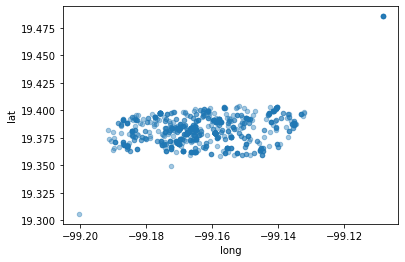

In [49]:
REcoords_data.plot(kind="scatter", x="long", y="lat", alpha=0.4)
plt.show()